In [8]:
import pandas as pd

# Load the dataset
df = pd.read_csv('triton_rezultati.csv')


In [9]:
for i in range(8):
    df[f'Avg_Utililisation {i}'] = df['Avg GPU Utilization'].str.extract(rf'GPU-{i}:(\d*\.?\d*)').astype(float)
    df[f'Avg_Power {i}'] = df['Avg GPU Power Usage'].str.extract(rf'GPU-{i}:(\d*\.?\d*)').astype(float)
    df[f'Max_Memory {i}'] = df['Max GPU Memory Usage'].str.extract(rf'GPU-{i}:(\d*\.?\d*)').astype(float)
    df[f'Total_Memory {i}'] = df['Total GPU Memory'].str.extract(rf'GPU-{i}:(\d*\.?\d*)').astype(float)
df.drop(columns=['Avg GPU Utilization'], inplace=True)
df.drop(columns=['Avg GPU Power Usage'], inplace=True)
df.drop(columns=['Max GPU Memory Usage'], inplace=True)
df.drop(columns=['Total GPU Memory'], inplace=True)

### concatenate test, batch_size, floating_point, kv_cache in one column
df['test'] = (df['test'].astype(str) + '_b' + df['batch_size'].astype(str) + '_' + df['floating_point'].astype(str) +
              '_kv' + df['kv_cache'].astype(str))
df.head()

,test,model,batch_size,floating_point,concurrency,kv_cache,Concurrency,Inferences/Second,Client Send,Network+Server Send/Recv,...,Max_Memory 5,Total_Memory 5,Avg_Utililisation 6,Avg_Power 6,Max_Memory 6,Total_Memory 6,Avg_Utililisation 7,Avg_Power 7,Max_Memory 7,Total_Memory 7
0,alpha_b1_fp16_kv0,gemma3,1,fp16,1:24:2,0,1,0.643508,50,719,...,4.773747e+10,1.922658e+11,0.0,191.025,4.639529e+10,1.922658e+11,0.0,191.174,2.471913e+10,1.922658e+11
1,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,19,1.185160,54,819,...,4.773747e+10,1.922658e+11,0.0,191.088,4.639529e+10,1.922658e+11,0.0,191.302,2.471913e+10,1.922658e+11
2,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,11,1.203680,48,752,...,4.773747e+10,1.922658e+11,0.0,191.356,4.639529e+10,1.922658e+11,0.0,191.630,2.471913e+10,1.922658e+11
3,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,5,1.203680,51,815,...,4.773747e+10,1.922658e+11,0.0,191.255,4.639529e+10,1.922658e+11,0.0,191.453,2.471913e+10,1.922658e+11
4,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,9,1.203680,54,820,...,4.773747e+10,1.922658e+11,0.0,191.330,4.639529e+10,1.922658e+11,0.0,191.466,2.471913e+10,1.922658e+11


In [10]:
#Zadrži samo relevantne kolone
df_filtered = df[
    ['test', 'model', 'batch_size', 'floating_point', 'kv_cache',
     'Concurrency', 'Inferences/Second',
     'p50 latency', 'p90 latency', 'p95 latency', 'p99 latency', 'response wait'
     ]
].copy()

# convert latency columns to seconds from microseconds
df_filtered['p50 latency'] = round(df_filtered['p50 latency'] / 1000000, 3)
df_filtered['p90 latency'] = round(df_filtered['p90 latency'] / 1000000, 3)
df_filtered['p95 latency'] = round(df_filtered['p95 latency'] / 1000000, 3)
df_filtered['p99 latency'] = round(df_filtered['p99 latency'] / 1000000, 3)



In [34]:
df_filtered

,test,model,batch_size,floating_point,kv_cache,Concurrency,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait
0,alpha_b1_fp16_kv0,gemma3,1,fp16,0,1,0.643508,1.543,1.546,1.546,1.561,1551326
1,alpha_b2_fp16_kv0,gemma3,2,fp16,0,19,1.185160,32.933,32.974,32.975,34.716,30954911
2,alpha_b2_fp16_kv0,gemma3,2,fp16,0,11,1.203680,18.114,18.157,19.758,19.797,18116455
3,alpha_b2_fp16_kv0,gemma3,2,fp16,0,5,1.203680,8.238,8.255,8.258,8.259,8238383
4,alpha_b2_fp16_kv0,gemma3,2,fp16,0,9,1.203680,14.816,16.491,16.581,18.096,14707821
...,...,...,...,...,...,...,...,...,...,...,...,...
251,zeta_b8_fp16_kv8192,meta-llama,8,fp16,8192,576,13.987400,329.144,330.833,331.261,331.560,323816420
252,zeta_b8_fp16_kv8192,meta-llama,8,fp16,8192,960,13.999600,512.343,549.324,549.672,550.244,519014491
253,zeta_b8_fp16_kv8192,meta-llama,8,fp16,8192,896,13.999600,476.798,512.808,513.208,513.610,485013772
254,zeta_b8_fp16_kv8192,meta-llama,8,fp16,8192,768,14.012000,404.210,438.246,438.514,439.444,415681413


In [11]:
# Add a combined metric
df_filtered['throughput_latency_ratio'] = df_filtered['Inferences/Second'] / df_filtered['p99 latency']
# For each test and model, get the row with the highest ratio
best_rows = df_filtered.loc[df_filtered.groupby(['test', 'model'])['throughput_latency_ratio'].idxmax()]

# order by highest throughput_latency_ratio
best_rows = best_rows.sort_values(by='throughput_latency_ratio', ascending=False)
# Display the best rows
best_rows.reset_index(drop=True, inplace=True)
best_rows.head(10)

# remove Concurrency column
best_rows.drop(columns=['Concurrency'], inplace=True)
# Display the best rows
best_rows.reset_index(drop=True, inplace=True)
best_rows.head(10)

,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
0,beta_b8_bf16_kv0,mistral,8,bf16,0,13.64180,2.917,3.045,3.082,3.165,2926345,4.310205
1,eta_b8_f16_kv4096,gemma3,8,f16,4096,4.58020,1.741,1.746,1.747,1.749,1749885,2.618754
2,gama_b8_bf16_kv128,gemma3,8,bf16,128,4.55551,1.747,1.750,1.751,1.753,1756092,2.598694
3,eta_b8_bf16_kv4096,gemma3,8,bf16,4096,4.50612,1.768,1.771,1.773,1.776,1774836,2.537230
4,beta_b8_bf16_kv0,gemma3,8,bf16,0,4.49378,1.765,1.774,1.774,1.776,1775727,2.530282
5,delta_b8_bf16_kv256,gemma3,8,bf16,256,4.77773,1.671,1.674,1.675,2.197,1676417,2.174661
6,epsilon_b8_bf16_kv4096,gemma3,8,bf16,4096,4.71600,1.691,1.696,1.697,2.230,1695595,2.114798
7,gama_b8_bf16_kv128,mistral,8,bf16,128,14.39490,4.551,6.609,6.913,7.215,4989904,1.995135
8,eta_b8_f16_kv4096,mistral,8,f16,4096,14.61710,4.439,7.348,7.552,7.768,4918528,1.881707
9,beta_b8_bf16_kv0,meta-llama,8,bf16,0,9.02461,4.403,4.839,4.929,5.139,4424416,1.756102


Matplotlib is building the font cache; this may take a moment.


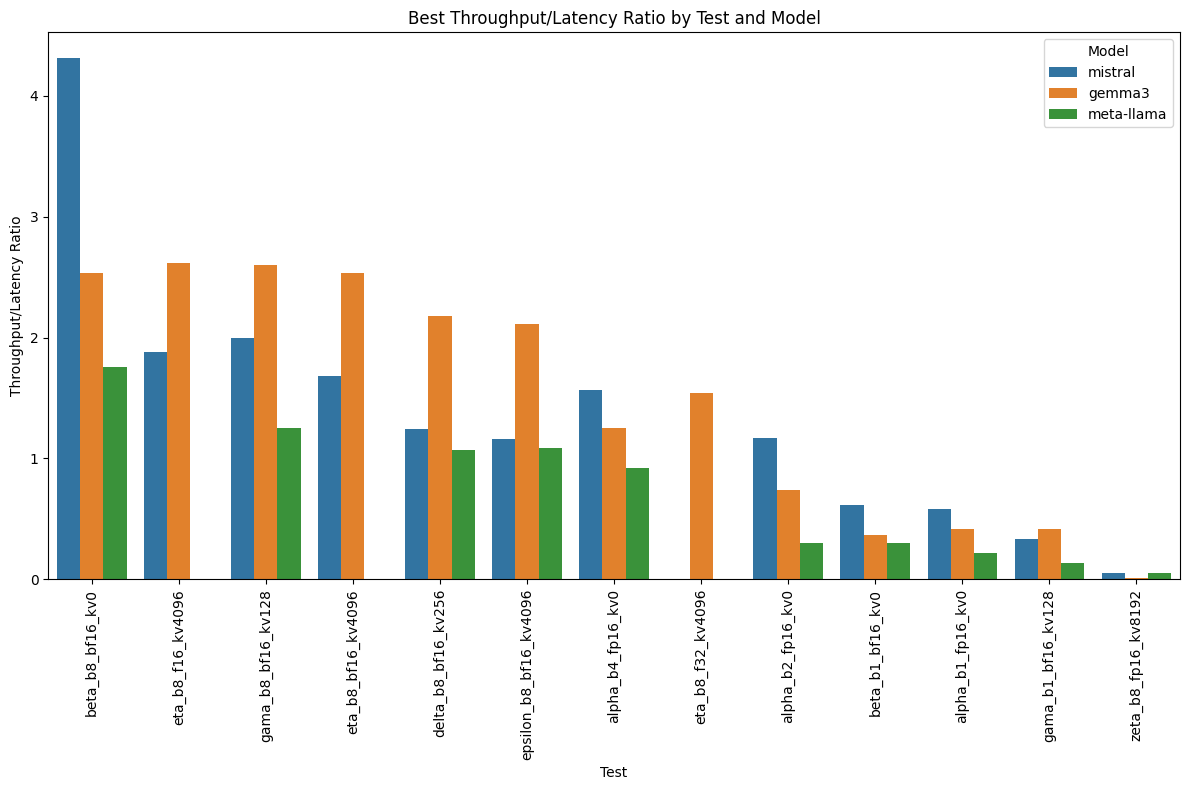

In [12]:
# plot the best rows
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))

sns.barplot(data=best_rows, x='test', y='throughput_latency_ratio', hue='model')
plt.title('Best Throughput/Latency Ratio by Test and Model')
plt.xlabel('Test')
plt.ylabel('Throughput/Latency Ratio')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


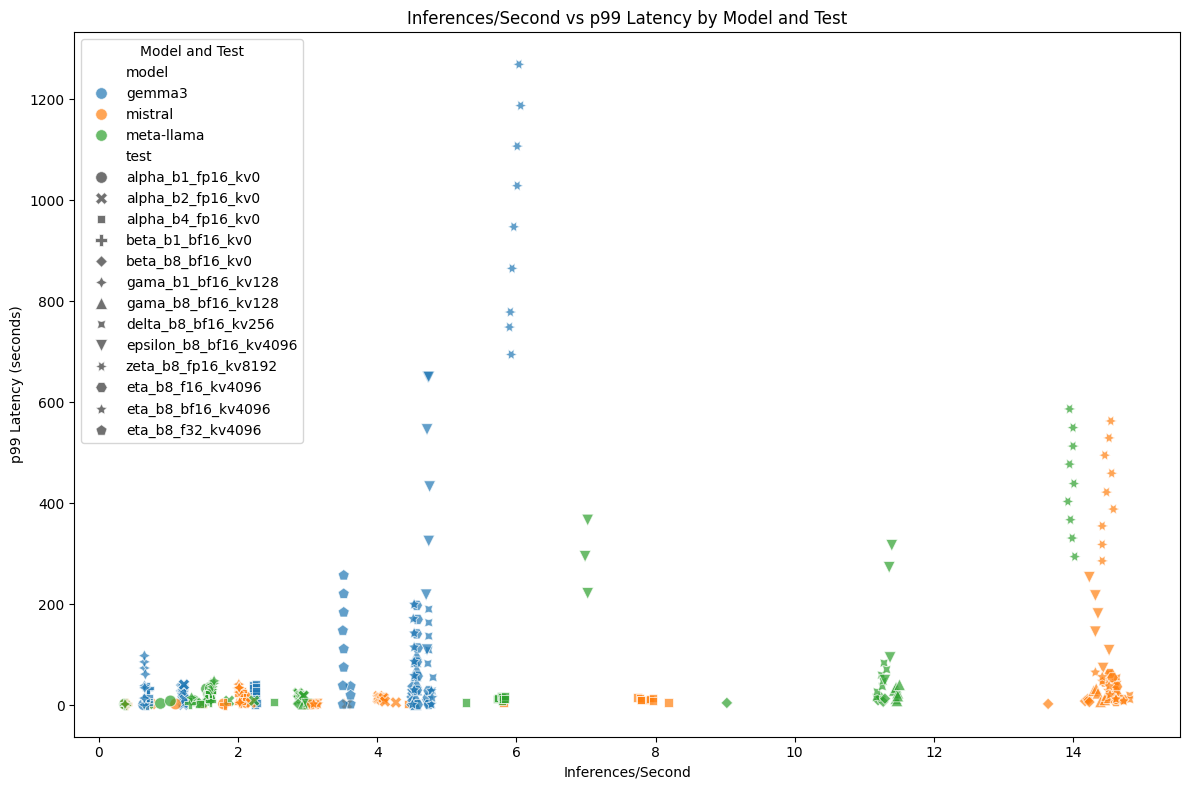

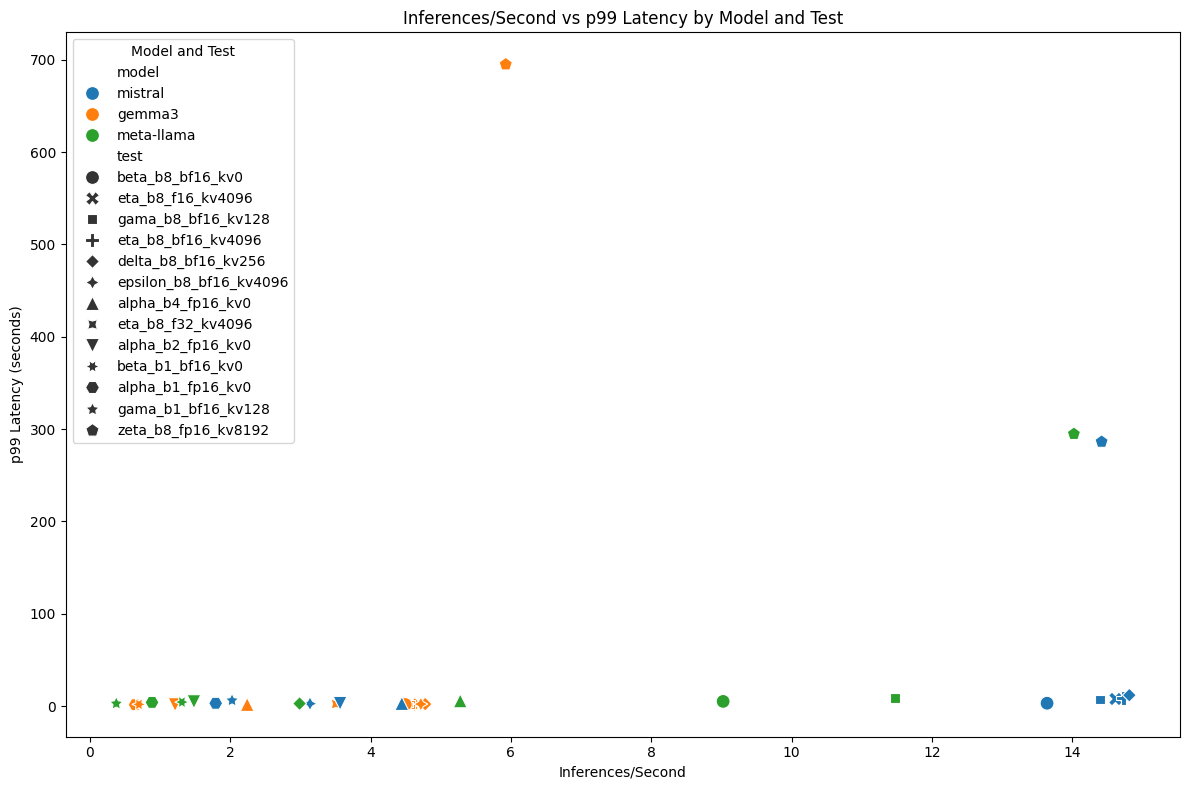

In [13]:
# scatter plot of Inferences/Second vs p99 latency
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_filtered, x='Inferences/Second', y='p99 latency', hue='model', style='test', s=70, alpha=0.7)
plt.title('Inferences/Second vs p99 Latency by Model and Test')
plt.xlabel('Inferences/Second')
plt.ylabel('p99 Latency (seconds)')
plt.legend(title='Model and Test')
plt.tight_layout()
plt.show()

# scatter plot of Inferences/Second vs p99 latency
plt.figure(figsize=(12, 8))
sns.scatterplot(data=best_rows, x='Inferences/Second', y='p99 latency', hue='model', style='test', s=100)
plt.title('Inferences/Second vs p99 Latency by Model and Test')
plt.xlabel('Inferences/Second')
plt.ylabel('p99 Latency (seconds)')
plt.legend(title='Model and Test')
plt.tight_layout()
plt.show()

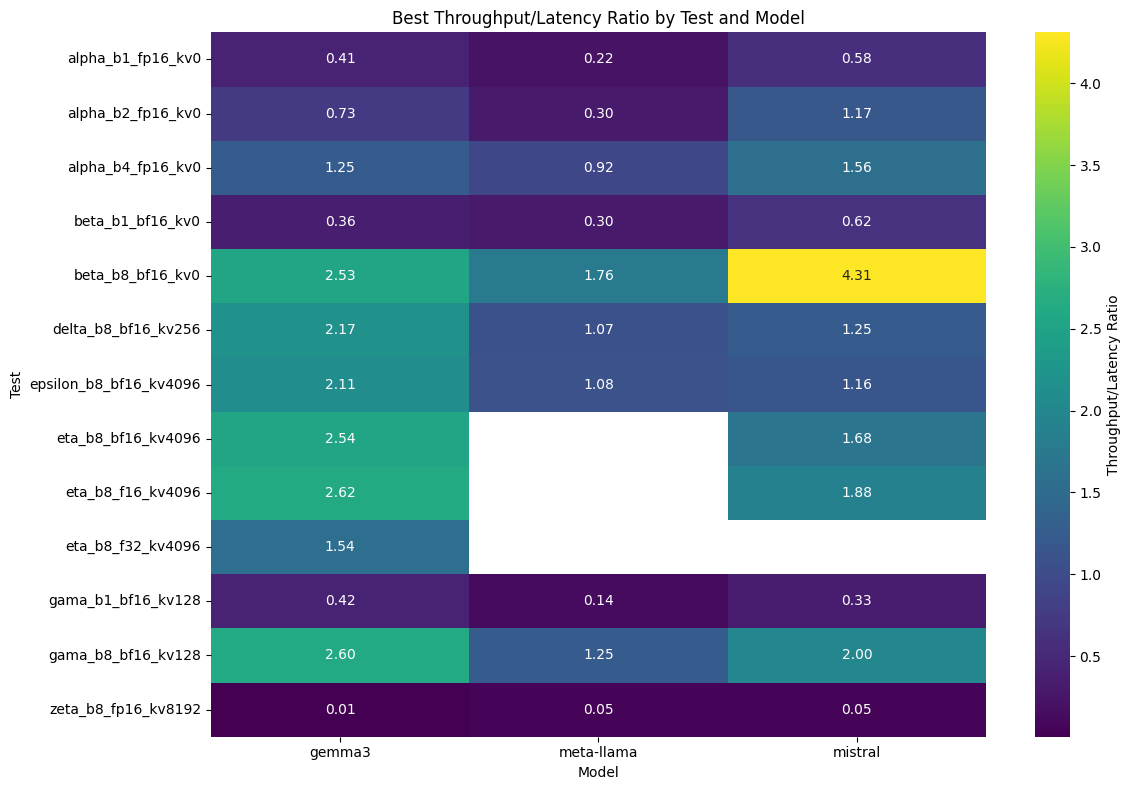

In [15]:
# crete a heatmap of the best rows
plt.figure(figsize=(12, 8))
sns.heatmap(
    best_rows.pivot_table(
        index='test', 
        columns='model', 
        values='throughput_latency_ratio'), 
    annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Throughput/Latency Ratio'})
plt.title('Best Throughput/Latency Ratio by Test and Model')
plt.xlabel('Model')
plt.ylabel('Test')
plt.tight_layout()
plt.show()
